# Syllable usage
- 2024-10-01: Notebook created, based on the previous notebooks:
    - [kf-2024-01-09-syllable-normalization.ipynb](https://github.com/lindermanlab/dirichlet-tucker/blob/killifish/killifish/kf-2024-01-09-syllable-normalization.ipynb)
    - [Pre - Minmax Scaling.ipynb](https://github.com/lindermanlab/dirichlet-tucker/blob/20240924-scaled-model/analysis/killifish/Pre%20-%20Minmax%20Scaling.ipynb)

In [56]:
%load_ext autoreload
%autoreload 2

from functools import partial
import itertools
import os

import numpy as onp

import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

import dtd
import dtd.data.killifish

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Load raw counts of data. No need to split by subject.
data_dir = os.getenv("KILLIFISH_DATA_DIR")
data = dtd.data.killifish.construct_subject_concatenated_dataset(data_dir)

syllable_counts = onp.asarray(data['tensor'])
name_and_age_labels = data['mode_0']

# syllable_labels`` are currently stored as ['<coarse_id>-<syllable_index>', ...]
# we discard the syllable index and just keep the coarse syllable label

syllable_labels = data['mode_2']
syllable_labels = [lbl.split('-')[0] for lbl in syllable_labels]

D, T, V = syllable_counts.shape
print(f"{syllable_counts.shape=}")

2024-10-01 14:37:26.463633: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


syllable_counts.shape=(14411, 144, 100)


## Temporary section. Delete after use

Examine fitted DTD behavioral topics. Do they exhibit the same symptoms of our scaled LDA model?

Not associated with this notebook.

In [ ]:
from collections import OrderedDict

SYLLABLE_PERM_DICT = OrderedDict([
    ('c0', [86, 16, 91, 26, 35, 27, 55, 57, 74,  0, 90,  3, 47]),
    ('c1', [67, 87, 63, 32, 54,  5, 69,  4, 49,  2, 80, 83, 18, 38, 11,  8, 66]),
    ('c2', [43, 78, 10, 20,31]),
    ('c3', [15, 76]),
    ('c4', [77, 84]),
    ('c5', [73, 24,  1, 44]),
    ('c6', [75, 62, 85]),
    ('c7', [41, 60, 88, 25, 53, 37, 82, 29, 50]),
    ('c8', [23, 79, 46, 81, 51, 59, 58, 94, 96, 65, 97, 56, 36,14, 17, 89]),
    ('c9', [30, 45, 71, 40, 93, 39, 52]),
    ('c10', [22, 70, 19, 92,  7, 13, 28, 64, 42, 61, 21, 99,  9, 33]),
    ('c11', [12, 34, 68,  6, 48, 95, 72, 98])
])

SYLLABLE_PERM = list(itertools.chain.from_iterable(SYLLABLE_PERM_DICT.values()))


In [45]:
from scipy.cluster.hierarchy import linkage, leaves_list

def set_syllable_cluster_ticks(ax=None, axis='x', font_kw={'fontsize': 'small', 'va': 'top'}):
    """Label specified axis with syllable _cluster_ names."""

    if ax is None:
        ax = plt.gca()

    cluster_names = list(SYLLABLE_PERM_DICT.keys())
    cluster_sizes = [len(v) for v in SYLLABLE_PERM_DICT.values()]
    
    maj_ticks = onp.cumsum([0,] + cluster_sizes) - 0.5
    min_ticks = onp.diff(maj_ticks) / 2 + maj_ticks[:-1]

    if axis == 'x':
        # Draw major ticks
        ax.set_xticks(maj_ticks)
        ax.tick_params(axis='x', which='major', length=5,
                       top=False, labeltop=False,
                       bottom=True, labelbottom=False)
        ax.grid(visible=True, which='major', axis='x', alpha=0.2, lw=0.5)

        # Annotate between the ticks
        ax.set_xticks(min_ticks, minor=True)
        ax.set_xticklabels(cluster_names, minor=True, fontdict=font_kw)
        ax.tick_params(axis='x', which='minor', pad=0.5,
                       top=False, labeltop=False,
                       bottom=False, labelbottom=True)
    else:
        # Draw major ticks
        ax.set_yticks(maj_ticks)
        ax.tick_params(axis='y', which='major', length=5, labelleft=False,)
        ax.grid(visible=True, axis='y', which='major', alpha=0.2, lw=0.5)

        # Annotate between the ticks
        ax.set_yticks(min_ticks, minor=True)
        ax.set_yticklabels(cluster_names, minor=True, fontdict=font_kw)
        ax.tick_params(axis='y', which='minor', left=False, labelleft=True)
    
    return ax

def draw_syllable_factors(F3, autosort=True, ax=None, im_kw={'cmap': 'magma', 'norm': mplc.LogNorm(0.5/100, 1.0)}):
    # Permute syllables to match our KL-clustering for better interpretability
    syllable_factors = onp.copy(F3)[:,SYLLABLE_PERM]
    K, D = syllable_factors.shape

    # Use hiearchical clustering on syllable factor ("behavioral topic") axis
    if autosort:
        method = 'centroid'
        metric = 'euclidean'
        topic_perm = leaves_list(linkage(syllable_factors, method, metric)).astype(int)

        syllable_factors = syllable_factors[topic_perm,:]
    else:
        topic_perm = onp.arange(K)

    # ------------------------------------------------------------------------
    ax = plt.gca() if ax is None else ax

    im = ax.imshow(syllable_factors, interpolation='none', aspect='auto', **im_kw)
    
    cbar = plt.colorbar(im, ax=ax, location='right', fraction=0.02, pad=0.05,)
    cbar.ax.tick_params(labelsize='x-small')
    # cbar.ax.text(0, 1, 'syllable usage',
    #              fontsize='small', ha='center', va='baseline',)

    # Annotate top with syllable clustering names
    set_syllable_cluster_ticks(ax, font_kw={'fontsize': 'small', 'color':'0.4',})

    # Visually demarcate each behavioral topic
    ax.set_yticks(onp.arange(K)-0.5)
    ax.tick_params(axis='y', labelleft=False)
    # ax.grid(visible=True, which='major', axis='y', alpha=0.8, lw=0.5)
    ax.set_ylabel('topics')
    ax.set_xlabel('syllables')

    return topic_perm

In [53]:
f = onp.load('/home/groups/swl1/eyz/dirichlet-tucker/analysis/killifish/dtd-128x32x64.npz')
topics = f['F3'][:,SYLLABLE_PERM]
K1, K2, K3 = f['G'].shape

Text(0.5, 0.93, 'Topic-syllable distribution of (128, 32, 64) model')

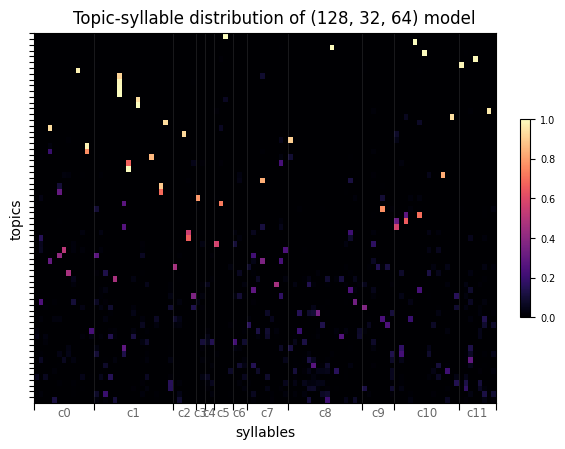

In [54]:
draw_syllable_factors(topics, im_kw={'cmap': 'magma', 'norm': mplc.Normalize(vmin=0, vmax=1)})

fig = plt.gcf()

fig.suptitle(f"Topic-syllable distribution of ({K1}, {K2}, {K3}) model", y=0.93)

In [41]:
f = onp.load('/home/groups/swl1/eyz/S5-KF/notebooks/dtd-1v5yqhac.npz')

topics = f['F3'][:,SYLLABLE_PERM]
K1, K2, K3 = f['G'].shape

Text(0.5, 0.93, 'Topic-syllable distribution of (50, 25, 50) model')

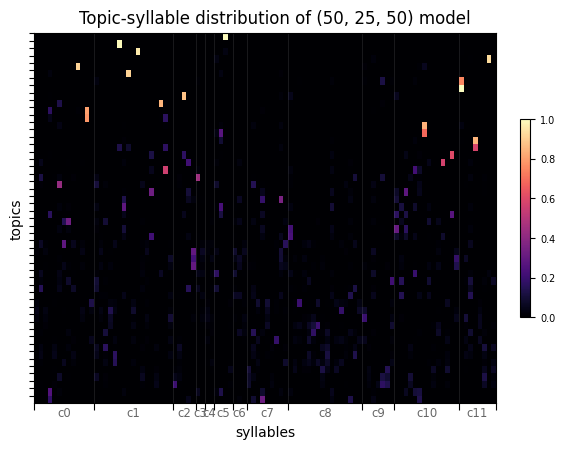

In [52]:
draw_syllable_factors(topics, im_kw={'cmap': 'magma', 'norm': mplc.Normalize(vmin=0, vmax=1)})

fig = plt.gcf()

fig.suptitle(f"Topic-syllable distribution of ({K1}, {K2}, {K3}) model", y=0.93)

## Normalized median syllable usage

In our scaled LDA model, we propose to use the empirical median syllable usage, normalized to sum to 1, as our initial value for the syllable scalings, $\sigma \in \Delta_V$. That is, we propose to let
$$
\sigma^{(0)}_v = \frac{f_\textrm{med}(x_{:,:,v})}{\sum_{v'} f_\textrm{med}(x_{:,:,v'})},
$$
where $f_\textrm{med}$ is the function returning the median value.

We take a look at these syllable usages across the whole dataset, split by time of day, and split by subject.

**Global vs. time-of-day**

Text(0.5, 1.0, 'global median syllable usage')

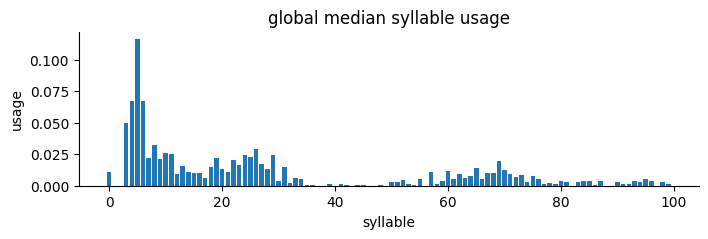

In [71]:
counts = syllable_counts.reshape(-1, V)  # flattent across D and T axes

sigmas = onp.median(counts, axis=0)
sigmas /= sigmas.sum()
sigmas.shape

# ---------------------------------------------

plt.figure(figsize=(8,2))
plt.bar(range(V), sigmas)
plt.xlabel('syllable'); plt.ylabel('usage')
sns.despine()

plt.title("global median syllable usage")


**Time-of-day**

We look at syllable usage during the day and the night.

The lights-on times are from 8AM (08:00) to 8PM (20:00).
Let's define the following two 6 hour time slices
- Daytime: 10AM-4PM (10:00-16:00)
- Nighttime: 10PM-4AM (00:00-04:00 && 22:00-00:00)

In [76]:
# 10 minute bins -> 6 bins / hr
daytime_slice = slice(10*6, 16*6)
nighttime_slices = [slice(0,4*6), slice(22*6, 24*6)]

daytime_counts = syllable_counts[:,daytime_slice,:].reshape(-1, V)

nighttime_counts = onp.concatenate(
    [syllable_counts[:,slc,:] for slc in nighttime_slices], axis=1
).reshape(-1, V)

assert daytime_counts.shape == nighttime_counts.shape

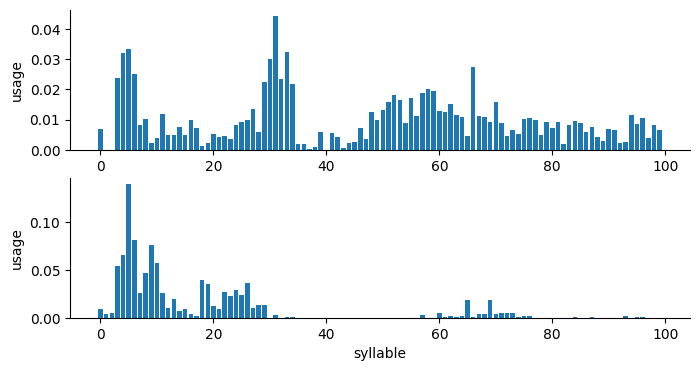

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,4))

for ax, counts in zip(axs, (daytime_counts, nighttime_counts)):
    sigmas = onp.median(counts, axis=0)
    sigmas /= sigmas.sum()
    
    ax.bar(range(V), sigmas)
    ax.set_xlabel('syllable'); ax.set_ylabel('usage')

sns.despine()

# plt.title("global median syllable usage")